# Topic Modeling using Latent Dirichlet Allocation on Aviation Safety Narrative data
This notebook is developed for undergraduate thesis project entitled\
`Unsupervised Approach for Analysis and Visualization of Aviation Safety Narratives`\
\
Developed and created by\
\
Eduardo Imanuel Bastian\
13619055\
Aircraft Design, Operation, and Maintenance Research Group\
Faculty of Mechanical and Aerospace Engineering\
Institut Teknologi Bandung

# 1. Importing dependencies

In [1]:
%%time
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.add("ft")
s_stemmer = SnowballStemmer("english")

%matplotlib inline

CPU times: user 1.47 s, sys: 318 ms, total: 1.79 s
Wall time: 2.52 s


In [2]:
# Read the data
corpus_boeing_path='2.TopicModelingBoeing/data/DataBoeing_2012-2021.csv'
corpus_boeing = pd.read_csv(corpus_boeing_path,header=1)
corpus_boeing.head()

,ACN,Date,Local Time Of Day,Locale Reference,State Reference,Relative Position.Angle.Radial,Relative Position.Distance.Nautical Miles,Altitude.AGL.Single Value,Altitude.MSL.Single Value,Latitude / Longitude (UAS),...,When Detected,Result,Contributing Factors / Situations,Primary Problem,Narrative,Callback,Narrative.1,Callback.1,Synopsis,Unnamed: 125
0,986867,201201,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,33000.0,NaN,...,In-flight,Flight Crew Returned To Departure Airport; Gen...,Aircraft,Aircraft,Approximately 5 minutes after level off at FL3...,NaN,[Narrative #2 had no additional information.],NaN,When ATC failed to clear them for their reques...,NaN
1,987083,201201,1201-1800,ZZZ.Airport,US,NaN,NaN,NaN,NaN,NaN,...,In-flight,Flight Crew Landed in Emergency Condition; Fli...,Aircraft,Aircraft,Electric stabilizer trim fail. We completed th...,NaN,[Narrative #2 had no additional information.],NaN,A B737-800's Electric Horizontal Stabilizer Tr...,NaN
2,987225,201201,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,12000.0,NaN,...,In-flight,Flight Crew Landed As Precaution; Flight Crew ...,Aircraft,Aircraft,Aircraft had a noticeable loud howl on takeoff...,NaN,[Narrative #2 had no additional information.],NaN,A B737-400 engine developed a howling sound du...,NaN
3,987717,201201,0001-0600,ZZZ.Airport,US,NaN,NaN,10.0,NaN,NaN,...,In-flight,Aircraft Equipment Problem Dissipated; Flight ...,Aircraft,Aircraft,On takeoff; at wheel lift off; a momentary los...,NaN,NaN,NaN,A B737-400 electrical system failed at lift of...,NaN
4,987840,201201,1201-1800,BOS.Airport,MA,40.0,10.0,3000.0,NaN,NaN,...,In-flight,Aircraft Automation Overrode Flight Crew; Flig...,Aircraft; Company Policy; Manuals,Aircraft,Enroute to BOS; #2 Navigation radio head faile...,NaN,NaN,NaN,A B737-800 Captain reported that the number 2 ...,NaN


You may skip the text preprocessing and load the saved preprocessed data on this cell instead

In [3]:
# LOAD THE BOEING DATA
lemm_text_arr=np.load('databoeing_2012_2021.npy')

# 2. Text preprocessing
The preprocessing steps are:
- Tokenization
- Lower-casing
- Punctuation removal
- Stop-words removal
- Lemmatization
- Abbreviations fixing

In [ ]:
def preprocess_text_col(df, column):
    lemm_text = []
    for i in range(df.shape[0]):
        doc = nlp(str(df[column][i]))
        # Lower-casing
        low_arr = [tok.lower_ for tok in doc]
        low_string = " ".join(low_arr)
        doc = nlp(low_string)
        # Stop-words removal and Punctuation removal
        stp_punc_arr = [str(tok) for tok in doc if not tok.is_stop and not tok.is_punct]
        stp_punc_string = " ".join(stp_punc_arr)
        doc = nlp(stp_punc_string)
        # Lemmatization
        lemm_arr = [tok.lemma_ for tok in doc]
        lemm_string = " ".join(lemm_arr)
        doc_lem = nlp(lemm_string)
        # Stemming
            #stem_arr = [s_stemmer.stem(tok) for tok in lemm_arr]
            #stem_string = " ".join(stem_arr)
            #stem_text.append(stem_string)
        lemm_text.append(lemm_string)
    return lemm_text

In [ ]:
df_abb=pd.DataFrame({'Old':[' acft ',' eng ',' flt ',
                            ' rptr ',' capt ',' lndg ',
                            ' rwy ',' emer ',' kt ',' tkof ',
                            ' gnd ',' apch ',' chk ',' pwr ',
                            ' evac ',' hyd ',' mech ',' ft ',
                            ' foot ',' turb ',' fa ',' tfc ',
                            ' spd ',' cab ',' ctlr ',' txwy ',
                            ' pax ',' clb ',' kias ',' deg ',
                            ' degs ',' kts ',' x ',' y ','zzz','zzz1'],
                     'Full Word':[' aircraft ',' engine ',' flight ',
                                 ' reporter ',' captain ',' landing ',
                                 ' runway ',' emergency ',' knot ',
                                 ' takeoff ',' ground ',' approach ',
                                 ' check ',' power ',' evacuation ',
                                 ' hydraulic ',' mechanic ',' feet ',
                                 ' feet ',' turbulence ',' attendant ',
                                 ' traffic ',' speed ',' attendant ',
                                 ' controller ',' taxiway ',
                                 ' passenger ',' climb ',' airspeed ',
                                 ' degree ',' degree ',' knot ',' ',' ',
                                  ' ',' '
                                 ]})

In [ ]:
# Preprocess the Boeing data
preprocessed_boeing_data=preprocess_text_col(corpus_boeing,'Narrative')

# Fixing the abbreviations
for i in range(len(preprocessed_boeing_data)):
    for j in range(len(df_abb)):
        preprocessed_boeing_data[i]=preprocessed_boeing_data[i].replace(df_abb['Old'][j],df_abb['Full Word'][j])

In [ ]:
# Save the narrative data into numpy array file `.npy`
np.save('databoeing_2012_2021.npy',preprocessed_boeing_data)

# 3. Topic Modeling using Latent Dirichlet Allocation (LDA)

## 3.1. LDA Preparation

In [4]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
from gensim.models import TfidfModel
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import tmtoolkit.topicmod.evaluate as tmeval

pyLDAvis.enable_notebook()

In [5]:
# Generate the dictionary
lemm_tokens = [doc.split() for doc in lemm_text_arr]
dictionary = Dictionary(lemm_tokens)
dictionary.filter_extremes(no_below=2, no_above=0.9) # no_below: a word must occur in 2 different documents 
                                                     # no_above: ignore certain word that occurs in 90% of the documents in corpus

# Generate the TF-IDF corpus
lemm_corpus = [dictionary.doc2bow(doc) for doc in lemm_tokens]
tfidf_model = TfidfModel(lemm_corpus)
corpus_tfidf = tfidf_model[lemm_corpus]

# Create corpus texts in the structure of list of lists
texts = []
for doc in lemm_text_arr:
    # split the string into a list of tokens
    tokens = doc.split()
    # append the list of tokens to the result list
    texts.append(tokens)

## 3.2. Choose the number of topic (n_topic)

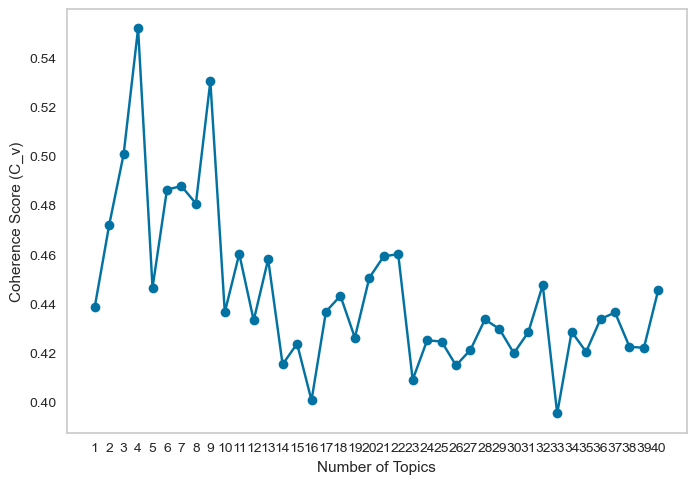

In [ ]:
## Define range of number of topics to try
min_topics = 1
max_topics = 40
step_size = 1
num_topics_range = range(min_topics, max_topics+1, step_size)

# Calculate coherence scores for different number of topics
coherence_scores = []
#coherence_tmtoolkit =[]
perplexity_scores =[]
for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus_tfidf,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=76)
    topic_words = []
    for i in range(lda_model.num_topics):
        topic_words.append([word for word, _ in lda_model.show_topic(i, topn=10)])
    cm = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
    # Calculate coherence score
    coherence_scores.append(cm.get_coherence())

    # Calculate perplexity score
    perplexity_scores.append(lda_model.log_perplexity(corpus_tfidf))

# Normalize the perplexity and coherence scores
perplexity_norm=(perplexity_scores-min(perplexity_scores))/(max(perplexity_scores)-min(perplexity_scores))
coherence_norm=(coherence_scores-min(coherence_scores))/(max(coherence_scores)-min(coherence_scores))

# Plot coherence score vs exclusivity score for different number of topics

plt.plot(num_topics_range, perplexity_norm, '-o',label='Perplexity Score')
plt.plot(num_topics_range, coherence_norm, '-o',label='Coherence Score')
plt.xlabel('Number of topics')
plt.ylabel('Normalized metrics')
plt.legend()
plt.grid(alpha=1)

## 3.3 Train the model
After the number of topics was choosen, one can train the LDA model

In [6]:
# Train the LDA model
n_clusters=4
lda_model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n_clusters,random_state=76)

In [7]:
# Visualize the important words in each topic
lda_display = gensimvis.prepare(lda_model, corpus_tfidf, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/opt/homebrew/Caskroom/miniforge/base/envs/tugasakhir/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 3.4. Export the data into csv for visualization

In [7]:
# Get the topic probabilities for each document
doc_topic_probs = lda_model.get_document_topics(corpus_tfidf)

# initialize empty lists to store the result
docs = []
topics = []
weights = []

# loop through each document
for i, doc in enumerate(doc_topic_probs):
    # get the topic with the highest probability and its probability score
    topic, score = max(doc, key=lambda x: x[1])
    
    # get the weight of the document for the corresponding topic
    #UNCOMMENT THIS CODE LATER#weight = doc[topic][1]
    
    # NEW CODE STARTS HERE
    
    doc_topics = [t[0] for t in doc]
    doc_weights = [t[1] for t in doc]
    
    if topic in doc_topics:
        # get the weight of the document for the corresponding topic
        weight = doc_weights[doc_topics.index(topic)]
    else:
        # assign a small weight to the topic for the current document
        weight = 0.001
    
    # NEW CODE ENDS HERE
    
    # append the document, topic, and weight to the result lists
    docs.append(i)
    topics.append(topic)
    weights.append(weight)

# create a dataframe from the result
df_doc_topic = pd.DataFrame({'Document': docs, 'Topic': topics, 'Weight': weights})
boeing_topic_proportion=df_doc_topic.copy()
# display the result
df_doc_topic.head(10)

# Export the DataFrame to CSV
#df_doc_topic.to_csv("doc_topic_proportion_boeing_4topic.csv", index=False)

,Document,Topic,Weight
0,0,0,0.896040
1,1,3,0.854685
2,2,0,0.898435
3,3,0,0.895095
4,4,1,0.455413
5,5,0,0.796309
6,6,1,0.880814
7,7,0,0.643356
8,8,0,0.532816
9,9,0,0.716047


In [8]:
# Get topic proportions for all documents
topic_proportions = [lda_model.get_document_topics(doc) for doc in corpus_tfidf]

# Convert to dataframe
topic_prop_df = pd.DataFrame()

for i, doc in enumerate(topic_proportions):
    topic_prop_df = topic_prop_df.append(pd.DataFrame(doc, columns=['topic', 'prop']), ignore_index=True)

# Group by topic and calculate total proportion
topic_prop_df = topic_prop_df.groupby('topic').sum().reset_index()
topic_prop_df['prop'] = topic_prop_df['prop']/topic_prop_df['prop'].sum() * 100

# Rename columns
topic_prop_df = topic_prop_df.rename(columns={'topic': 'Topics', 'prop': 'Proportions'})

# Sort by proportions in descending order
topic_prop_df = topic_prop_df.sort_values('Proportions', ascending=False)

# Reset index
topic_prop_df = topic_prop_df.reset_index(drop=True)

topic_prop_df.head(10)

# Export the DataFrame to CSV
#topic_prop_df.to_csv("topics_proportion_boeing_4topic.csv", index=False)

/var/folders/bf/22wqlvvd337dp3ftdrzyy1tw0000gn/T/ipykernel_19393/1260020995.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_prop_df = topic_prop_df.append(pd.DataFrame(doc, columns=['topic', 'prop']), ignore_index=True)
/var/folders/bf/22wqlvvd337dp3ftdrzyy1tw0000gn/T/ipykernel_19393/1260020995.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_prop_df = topic_prop_df.append(pd.DataFrame(doc, columns=['topic', 'prop']), ignore_index=True)
/var/folders/bf/22wqlvvd337dp3ftdrzyy1tw0000gn/T/ipykernel_19393/1260020995.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_prop_df = topic_prop_df.append(pd.DataFrame(doc, columns=['topic', 'prop']), ignore_index=True)
/var/folders/bf/22wqlvvd337dp3ftdrzyy1tw000

,Topics,Proportions
0,0,38.402615
1,1,28.041939
2,2,18.027674
3,3,15.527773


## 3.5. Create the result dataframe for dashboard (ACN as Index)


In [9]:
corpus_check=[corpus_boeing['ACN'],corpus_boeing['State Reference'],corpus_boeing['Primary Problem'],corpus_boeing['Make Model Name'],corpus_boeing['Flight Phase'],corpus_boeing['Function']]
for item in corpus_check:
    item.fillna(value="Unidentified",inplace=True)

In [10]:
df_doc_topic=pd.concat([df_doc_topic,corpus_boeing['ACN'],corpus_boeing['State Reference'],corpus_boeing['Primary Problem'],corpus_boeing['Make Model Name'],corpus_boeing['Flight Phase'],corpus_boeing['Function']],axis=1)

#SPLIT THE FUNCTION
# reset the index of the dataframe
df_doc_topic = df_doc_topic.reset_index(drop=True)

split_values = df_doc_topic['Function'].str.split(';', expand=True)

# Rename the split columns as Function 1, Function 2, Function 3
split_values.columns = [f'Function {i+1}' for i in range(split_values.shape[1])]

# Concatenate the split columns with the original dataframe
df_doc_topic = pd.concat([df_doc_topic, split_values], axis=1)

# Drop the old Function column
df_doc_topic = df_doc_topic.drop('Function', axis=1)

# SPLIT THE FLIGHT PHASE
split_values = df_doc_topic['Flight Phase'].str.split(';', expand=True)

# Rename the split columns as Function 1, Function 2, Function 3
split_values.columns = [f'Flight Phase {i+1}' for i in range(split_values.shape[1])]

# Concatenate the split columns with the original dataframe
df_doc_topic = pd.concat([df_doc_topic, split_values], axis=1)

# Drop the old Function column
df_doc_topic = df_doc_topic.drop('Flight Phase', axis=1)

df_doc_topic.head(10)

# Export the DataFrame to CSV

,Document,Topic,Weight,ACN,State Reference,Primary Problem,Make Model Name,Function 1,Function 2,Function 3,Function 4,Flight Phase 1,Flight Phase 2,Flight Phase 3,Flight Phase 4,Flight Phase 5,Flight Phase 6
0,0,0,0.896040,986867,US,Aircraft,B737-400,Pilot Not Flying,Captain,None,None,Cruise,None,None,None,None,None
1,1,3,0.854685,987083,US,Aircraft,B737-800,Pilot Not Flying,First Officer,None,None,Climb,None,None,None,None,None
2,2,0,0.898435,987225,US,Aircraft,B737-400,Captain,Pilot Not Flying,None,None,Climb,None,None,None,None,None
3,3,0,0.895095,987717,US,Aircraft,B737-400,Captain,None,None,None,Takeoff / Launch,None,None,None,None,None
4,4,1,0.455413,987840,MA,Aircraft,B737-800,Captain,Pilot Flying,None,None,Final Approach,None,None,None,None,None
5,5,0,0.796309,988108,US,Human Factors,B737-700,Pilot Flying,Captain,None,None,Climb,None,None,None,None,None
6,6,1,0.880814,988111,CA,Procedure,B747-400,Captain,Pilot Not Flying,None,None,Takeoff / Launch,None,None,None,None,None
7,7,0,0.643356,988179,TX,Aircraft,B757-200,Captain,Pilot Not Flying,None,None,Cruise,None,None,None,None,None
8,8,0,0.532816,988193,IL,Human Factors,B737-800,Pilot Not Flying,Captain,None,None,Initial Climb,None,None,None,None,None
9,9,0,0.716047,988252,UT,Human Factors,B737-800,Enroute,None,None,None,Cruise,None,None,None,None,None


## 3.6. Create the result dataframe for dashboards (Topic as index)

In [11]:
# group the documents by topic
grouped = df_doc_topic.copy().groupby('Topic')

# create an empty list to store the results
results = []

# loop through each group and retrieve the top 10 documents with the highest weight
for name, group in grouped:
    top_docs = group.nlargest(10, 'Weight')
    # append the results to the list
    results.append(top_docs)

# concatenate the results into a single dataframe
top_docs_df = pd.concat(results, axis=0)

# sort the dataframe by topic and weight
top_docs_df = top_docs_df[['Topic','Weight','ACN']].sort_values(['Topic', 'Weight'], ascending=[True, False]).reset_index(drop=True)
top_docs_df.rename(columns={'Weight':'Topic Weight'})

# Get the top 10 words for each topic and store them in a DataFrame
topic_words = []
for i in range(lda_model.num_topics):
    topic_words.append(lda_model.show_topic(i, topn=10))

words_df = pd.DataFrame(columns=["Topic number", "Top word", "Word weight"])

for i, words in enumerate(topic_words):
    for j, (word, weight) in enumerate(words):
        words_df.loc[i*10+j] = [i, word, weight]

#Concatenate the dataframe
Topic_dataframe=pd.concat([top_docs_df,words_df],axis=1)
Topic_dataframe.drop(columns='Topic number',inplace=True)

In [12]:
Topic_dataframe['Topic title']=np.zeros(len(Topic_dataframe))
Topic_dataframe['Topic proportion']=np.zeros(len(Topic_dataframe))

# Labeling the topic title
Topic_dataframe['Topic title']=np.where(Topic_dataframe['Topic'] == 0, 'Title Topic 0', Topic_dataframe['Topic title'])
Topic_dataframe['Topic title']=np.where(Topic_dataframe['Topic'] == 1, 'Title Topic 1', Topic_dataframe['Topic title'])
Topic_dataframe['Topic title']=np.where(Topic_dataframe['Topic'] == 2, 'Title Topic 2', Topic_dataframe['Topic title'])
Topic_dataframe['Topic title']=np.where(Topic_dataframe['Topic'] == 3, 'Title Topic 3', Topic_dataframe['Topic title'])

# Topic proportion
Topic_dataframe['Topic proportion']=np.where(Topic_dataframe['Topic'] == 0, topic_prop_df['Proportions'][0], Topic_dataframe['Topic proportion'])
Topic_dataframe['Topic proportion']=np.where(Topic_dataframe['Topic'] == 1, topic_prop_df['Proportions'][1], Topic_dataframe['Topic proportion'])
Topic_dataframe['Topic proportion']=np.where(Topic_dataframe['Topic'] == 2, topic_prop_df['Proportions'][2], Topic_dataframe['Topic proportion'])
Topic_dataframe['Topic proportion']=np.where(Topic_dataframe['Topic'] == 3, topic_prop_df['Proportions'][3], Topic_dataframe['Topic proportion'])

Topic_dataframe

,Topic,Weight,ACN,Top word,Word weight,Topic title,Topic proportion
0,0,0.943782,1463011,engine,0.003910,Title Topic 0,38.402615
1,0,0.942585,1725655,fuel,0.003270,Title Topic 0,38.402615
2,0,0.942423,1033738,cabin,0.002932,Title Topic 0,38.402615
3,0,0.941651,1557529,atc,0.002659,Title Topic 0,38.402615
4,0,0.941585,1706609,altitude,0.002644,Title Topic 0,38.402615
5,0,0.940978,1545916,aircraft,0.002578,Title Topic 0,38.402615
6,0,0.940941,1385494,fire,0.002573,Title Topic 0,38.402615
7,0,0.939980,1804712,checklist,0.002565,Title Topic 0,38.402615
8,0,0.939352,1104304,feet,0.002430,Title Topic 0,38.402615
9,0,0.938891,1333091,1,0.002404,Title Topic 0,38.402615


## 3.7. Import the files into `.csv`

In [13]:
# Export the DataFrames to CSV
df_doc_topic.to_csv("ACN_Dataframe.csv", index=False)
Topic_dataframe.to_csv("Topic_dataframe.csv", index=False)